## Исследовательский анализ данных в Python и проверка гипотез.

Автор: Зайцев Виталий.
Дата: 18.09.2025 г.

В нашем распоряжении данные о бронировании билетов на сервисе Афиша за период с 1 июня по 31 октября 2024 года.  
(Все названия в данных заменены на вымешленные.)

**Цели и задачи**

*Цель*  
Разобраться, почему произошло изменение в пользовательском спросе в конце октября 2024 г. (упал спрос).

*Задачи*  
- изучить распределение заказов по сегментам и сезонности
- исследовать осеннюю активность пользователей
- выявить популярные события и партнеров
- провести статистический анализ данных

<a id="label_00"></a>
#### Содержание проекта 

---
0. [Описание данных.](#label_0)
1. [Знакомство с данными: загрузка и знакомство с данными.](#label_1)
2. [Предобработка данных и подготовка их к исследованию.](#label_2)
   1. [Проверка на дубликаты.](#label_2_1)
   2. [Объединение таблиц](label_2_2)
   3. [Преобразование типов данных.](#label_2_3)
   4. [Изучяем значения в ключевых столбцах.](#label_2_4)
   5. [Создаем новые столбцы](#label__2_5)
3. [Исследовательский анализ данных.](#label_3)
    1. [Анализ распределения заказов по сегментам и их сезонные изменения.](#label_3_1)
    2. [Осенняя активность пользователей.](#label_3_2)
    3. [Популярные события и партнёры.](#label_3_3)
4. [Статистический анализ данных.](#label_4)
5. [Общий вывод и рекомендации.](#label_5)

<a id="label_0"></a>
### Описание данных.

Таблица `final_tickets_orders_df.csv` включает информацию обо всех заказах билетов, совершённых с двух типов устройств — мобильных и стационарных:
- `order_id` — уникальный идентификатор заказа.
- `user_id` — уникальный идентификатор пользователя.
- `created_dt_msk` — дата создания заказа (московское время).
- `created_ts_msk` — дата и время создания заказа (московское время).
- `event_id` — идентификатор мероприятия из таблицы events.
- `cinema_circuit` — сеть кинотеатров. Если не применимо, то здесь будет значение 'нет'.
- `age_limit` — возрастное ограничение мероприятия.
- `currency_code` — валюта оплаты, например rub для российских рублей.
- `device_type_canonical` — тип устройства, с которого был оформлен заказ, например mobile для мобильных устройств, desktop для стационарных.
- `revenue` — выручка от заказа.
- `service_name` — название билетного оператора.
- `tickets_count` — количество купленных билетов.
- `total` — общая сумма заказа.
В данные также был добавлен столбец `days_since_prev` с количеством дней с предыдущей покупки для каждого пользователя. Если покупки не было, то данные содержат пропуск.

Таблица `final_tickets_events_df.csv` содержит информацию о событиях, включая город и регион события, а также информацию о площадке проведения мероприятия. Датасет содержит такие поля:
- `event_id` — уникальный идентификатор мероприятия.
- `event_name` — название мероприятия. Аналог поля event_name_code из исходной базы данных.
- `event_type_description` — описание типа мероприятия.
- `event_type_main` — основной тип мероприятия: театральная постановка, концерт и так далее.
- `organizers` — организаторы мероприятия.
- `region_name` — название региона.
- `city_name` — название города.
- `venue_id` — уникальный идентификатор площадки.
- `venue_name` — название площадки.
- `venue_address` — адрес площадки.

Для перевода из тенге в рубли есть таблица `final_tickets_tenge_df.csv` с информацией о курсе тенге к российскому рублю за 2024 год. Значения в рублях представлено для 100 тенге. Датасет содержит такие поля:
- `nominal` — номинал (100 тенге);
- `data` — дата;
- `curs` — курс тенге к рублю;
- `cdx` — обозначение валюты (kzt).

[к содержанию](#label_00)

---

In [1]:
# загрузим необходимые библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# загружаем статистические тесты
from scipy.stats import ttest_ind
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.power import NormalIndPower
from statsmodels.stats.proportion import proportion_effectsize

<a id="label_1"></a>
### 1. Знакомство с данными: загрузка и знакомство с данными.

In [2]:
# загужаем данные
try:
    orders_df = pd.read_csv('/datasets/final_tickets_orders_df.csv')
except:
    orders_df = pd.read_csv('C:/Files/Ya_Practicum/Projects/Final_proj/final_tickets_orders_df.csv')

try:
    events_df = pd.read_csv('/datasets/final_tickets_events_df.csv')
except:
    events_df = pd.read_csv('C:/Files/Ya_Practicum/Projects/Final_proj/final_tickets_events_df.csv')

try:
    tenge_df = pd.read_csv('/datasets/final_tickets_tenge_df.csv')
except:
    tenge_df = pd.read_csv('C:/Files/Ya_Practicum/Projects/Final_projs/final_tickets_tenge_df.csv')

In [3]:
# посмотрим, что в таблицах
for df in [orders_df, events_df, tenge_df]:
    display(df.sample(5))
    display(df.info())

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,service_name,tickets_count,total,days_since_prev
214337,2934598,b34524f63004132,2024-06-08,2024-06-08 10:47:27,501198,нет,0,rub,mobile,35.89,Билеты в руки,3,717.75,0.0
46250,7979003,1c2a2133e1df1b4,2024-09-03,2024-09-03 13:23:23,41089,нет,16,rub,desktop,254.03,Тебе билет!,4,2540.28,0.0
41586,2767703,18e9aead0a393e7,2024-10-27,2024-10-27 17:30:06,500862,нет,12,rub,mobile,902.74,Облачко,3,8206.70,0.0
64722,7424059,2c8092b69b753cc,2024-07-31,2024-07-31 11:52:57,553512,нет,6,rub,mobile,0.00,Билеты без проблем,4,0.00,0.0
251068,8077603,d962a8ea254322e,2024-10-26,2024-10-26 16:43:14,367631,нет,18,rub,mobile,83.69,Билеты без проблем,3,2092.14,0.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290849 entries, 0 to 290848
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   order_id               290849 non-null  int64  
 1   user_id                290849 non-null  object 
 2   created_dt_msk         290849 non-null  object 
 3   created_ts_msk         290849 non-null  object 
 4   event_id               290849 non-null  int64  
 5   cinema_circuit         290849 non-null  object 
 6   age_limit              290849 non-null  int64  
 7   currency_code          290849 non-null  object 
 8   device_type_canonical  290849 non-null  object 
 9   revenue                290849 non-null  float64
 10  service_name           290849 non-null  object 
 11  tickets_count          290849 non-null  int64  
 12  total                  290849 non-null  float64
 13  days_since_prev        268909 non-null  float64
dtypes: float64(3), int64(4), object(7)
m

None

,event_id,event_name,event_type_description,event_type_main,organizers,region_name,city_name,city_id,venue_id,venue_name,venue_address
691,32291,b38f0ff8-8445-4877-80ce-3c6a3b278b20,опера,театр,№5051,Светополянский округ,Глиноград,54,4174,"Творческое объединение ""Rebel"" Лтд","ул. Приозерная, д. 4"
5477,354651,20165b73-7202-48df-a5e3-fd8cd1a70554,спектакль,театр,№5028,Каменевский регион,Глиногорск,213,2704,"Летний фестиваль ""Симфония"" Лтд","бул. Боровой, д. 8/1 стр. 43"
8024,454057,9313228f-6bbc-4f50-a5b8-d744dafd48dd,событие,выставки,№1796,Широковская область,Радужнополье,35,3123,"Музей истории ""Mission"" Лимитед","пр. Технический, д. 1/5 стр. 8"
9390,495491,e2452457-196b-4690-b614-3b93c7abde9e,событие,другое,№4510,Каменевский регион,Глиногорск,213,3676,"Лаборатория по созданию комиксов ""Успех"" Инк","наб. Строителей, д. 64"
16440,551789,34047c8c-a549-4d2f-b330-ac77e4f55469,спектакль,театр,№3891,Дальнезорский край,Рощино,195,2363,"Арт-лаборатория ""Способы"" Инкорпорэйтед","наб. Дружбы, д. 6 стр. 71"


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22427 entries, 0 to 22426
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   event_id                22427 non-null  int64 
 1   event_name              22427 non-null  object
 2   event_type_description  22427 non-null  object
 3   event_type_main         22427 non-null  object
 4   organizers              22427 non-null  object
 5   region_name             22427 non-null  object
 6   city_name               22427 non-null  object
 7   city_id                 22427 non-null  int64 
 8   venue_id                22427 non-null  int64 
 9   venue_name              22427 non-null  object
 10  venue_address           22427 non-null  object
dtypes: int64(3), object(8)
memory usage: 1.9+ MB


None

,data,nominal,curs,cdx
309,2024-11-14,100,19.8739,kzt
246,2024-09-12,100,19.1152,kzt
180,2024-07-08,100,18.5395,kzt
218,2024-08-15,100,18.7730,kzt
287,2024-10-23,100,20.0531,kzt


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357 entries, 0 to 356
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   data     357 non-null    object 
 1   nominal  357 non-null    int64  
 2   curs     357 non-null    float64
 3   cdx      357 non-null    object 
dtypes: float64(1), int64(1), object(2)
memory usage: 11.3+ KB


None

Загруженные таблицы имеют snake-тип названий столбцов.

Таблица `orders_df` содержит 290849 строк, пропуски только в столбце `days_since_prev`, что говорит только об одной покупке (не было предыдущих). Типы данных соответствуют данным, кроме дат - они в формате `object`, нужно привести к формату даты.

Таблица `events_df` содержит 22427 строк, пропусков нет, типы данных соответствуют данным.

Таблица `tenge_df` содержит 357 строк, пропусков нет, типы данных соответствуют данным, кроме дат - они в формате `object`, нужно привести к формату даты.

In [4]:
# приведем столбцы с датами к типу дат
orders_df['created_dt_msk'] = pd.to_datetime(orders_df['created_dt_msk'])
orders_df['created_ts_msk'] = pd.to_datetime(orders_df['created_ts_msk'])
tenge_df['data'] = pd.to_datetime(tenge_df['data'])

**Промежуточные выводы**
- Пропусков в таблицах нет (кроме столбца `days_since_prev` в таблице `orders_df`, но это понятные пропуски).
- Типы данных соответствуют содержимому.

[к содержанию](#label_00)

---


<a id="label_2"></a>
### 2. Предобработка данных и подготовка их к исследованию.

<a id="label_2_1"></a>
#### 2.1 Проверка на дубликаты.

In [5]:
# проверим данные на явные дубликаты
tables_dict = {'orders_df':orders_df, 'events_df':events_df, 'tenge_df':tenge_df}
for name, df in tables_dict.items():
    dupl = df.duplicated().sum()
    if dupl == 0:
        print(f'В таблице {name} дубликатов нет')
    else: 
        print(f'В таблице {name} найдено {dupl} дубликатов')

В таблице orders_df дубликатов нет
В таблице events_df дубликатов нет
В таблице tenge_df дубликатов нет


Попробуем найти неявные дубликаты. Они могут быть в следующих столбцах:
- таблица `orders_df`, столбец `service_name` - могут быть одни названия, но написанные по разному.
- таблица `events_df`, столбцы `venue_name` и `venue_address` могут иметь одно название, но разный адрес, или наоборот.

In [6]:
# выведим уникальные названия билетных операторов
orders_df['service_name'].unique()

array(['Край билетов', 'Мой билет', 'За билетом!', 'Лови билет!',
       'Билеты без проблем', 'Облачко', 'Лучшие билеты', 'Прачечная',
       'Быстробилет', 'Дом культуры', 'Весь в билетах', 'Билеты в руки',
       'Тебе билет!', 'Show_ticket', 'Городской дом культуры', 'Яблоко',
       'Билет по телефону', 'Выступления.ру', 'Росбилет',
       'Шоу начинается!', 'Мир касс', 'Восьмёрка', 'Телебилет',
       'Crazy ticket!', 'Реестр', 'Быстрый кассир', 'КарандашРУ',
       'Радио ticket', 'Дырокол', 'Вперёд!', 'Кино билет', 'Цвет и билет',
       'Зе Бест!', 'Тех билет', 'Лимоны', 'Билеты в интернете'],
      dtype=object)

Видим, что в этом столбце нет одинаковых названий, т.е. неявных дубликатов в этом столце нет.

In [7]:
# сгруппируем таблицу events_df по столбцу venue_name и посчитаем кол-во уникальных адресов
events_df.groupby('venue_name').agg({'venue_address':'nunique'}).query('venue_address > 1')['venue_address']

venue_name
Арт-объединение "Сделайка" Инк                          2
Детская художественная школа "Echo" Инк                 2
Клуб исторических реконструкций "Палитра" и партнеры    2
Клуб стендап-комедии "Символ" Лтд                       2
Мастерская графического дизайна "Успех" Лтд             2
Ремесленный центр "Лестница" Лтд                        2
Санкт-Петербургский дом культуры "Пегас" Лимитед        2
Центр традиционной культуры "Стройка" Лтд               2
Name: venue_address, dtype: int64

Таких организаций 8, у которых есть 2 разных адреса проведения мероприятия. Правильно было бы найти эти организации по интернету и уточнить их реальный адрес, а потом заменить в данных некорректный второй адрес на верный. Но т.к. у нас тут выдуманные организации, мы это сделать не можем. По большому счету, адрес у нас нигде в исследовании не используется, поэтому можно оставить как есть. Заказчику нужно рекомендовать проверить реальные адреса реальных 8 организаций из их данных.

In [8]:
# проверим теперь, а нет ли 2х и более организаций по одному адресу
events_df.groupby('venue_address').agg({'venue_name':'nunique'}).query('venue_name > 1')['venue_name']

Series([], Name: venue_name, dtype: int64)

Таких организаций нет, значит неявных дубликатов организаций с одним адресом нет в данных.

In [9]:
# проанализируем категориальные колонки
for column in ['age_limit', 'currency_code', 'device_type_canonical', 'service_name']:
    print(f"\nКолонка: {column}")
    print("Уникальные значения:", orders_df[column].unique())
    print("Пропущенные значения:", orders_df[column].isna().sum())
    print("Кол-во значений:")
    print(orders_df[column].value_counts(dropna=False), "\n")


Колонка: age_limit
Уникальные значения: [16  0 18 12  6]
Пропущенные значения: 0
Кол-во значений:
16    78579
12    62557
0     61487
6     52173
18    36053
Name: age_limit, dtype: int64 


Колонка: currency_code
Уникальные значения: ['rub' 'kzt']
Пропущенные значения: 0
Кол-во значений:
rub    285780
kzt      5069
Name: currency_code, dtype: int64 


Колонка: device_type_canonical
Уникальные значения: ['mobile' 'desktop']
Пропущенные значения: 0
Кол-во значений:
mobile     232679
desktop     58170
Name: device_type_canonical, dtype: int64 


Колонка: service_name
Уникальные значения: ['Край билетов' 'Мой билет' 'За билетом!' 'Лови билет!'
 'Билеты без проблем' 'Облачко' 'Лучшие билеты' 'Прачечная' 'Быстробилет'
 'Дом культуры' 'Весь в билетах' 'Билеты в руки' 'Тебе билет!'
 'Show_ticket' 'Городской дом культуры' 'Яблоко' 'Билет по телефону'
 'Выступления.ру' 'Росбилет' 'Шоу начинается!' 'Мир касс' 'Восьмёрка'
 'Телебилет' 'Crazy ticket!' 'Реестр' 'Быстрый кассир' 'КарандашРУ'
 'Ради

Аномалий в этих колонках нет, следующие колнки имеют небольшое кол-во значений:
- `age_limit` - 5
- `currency_code`- 2
- `device_type_canonical` - 2

[к содержанию](#label_00)

---

<a id="label_2_2"></a>
#### 2.2 Объединение таблиц.

Объединим все 3 таблицы в одну.

In [10]:
df = orders_df.merge(events_df, on='event_id', how='left').merge(tenge_df, left_on='created_dt_msk', right_on='data', how='left')
df.sample(5)

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,...,region_name,city_name,city_id,venue_id,venue_name,venue_address,data,nominal,curs,cdx
174795,8351189,8d974a49ae0cd5b,2024-09-05,2024-09-05 21:59:29,541746,нет,16,rub,mobile,80.82,...,Крутоводская область,Никольянов,191.0,4368.0,"Сообщество художников ""Сказка"" Лимитед","пр. Никитина, д. 3 к. 183",2024-09-05,100,18.4217,kzt
142604,2583060,75a1435d305cbe9,2024-08-05,2024-08-05 17:59:37,201459,нет,16,rub,mobile,77.97,...,Светополянский округ,Глиноград,54.0,4443.0,"Центр культурного наследия ""Объединение"" и пар...","бул. Карбышева, д. 50",2024-08-05,100,18.0536,kzt
141033,2846003,72fd90994d5e8e0,2024-10-17,2024-10-17 18:02:29,426989,нет,6,rub,mobile,187.05,...,Речиновская область,Дальнесветск,65.0,3254.0,"Академия прикладного искусства ""Эссенция"" и па...","ш. Новгородское, д. 23 стр. 7/2",2024-10-17,100,19.9534,kzt
259707,1032459,e2c6cc9956748c8,2024-08-25,2024-08-25 17:35:15,515996,нет,0,rub,mobile,42.25,...,Речиновская область,Дальнесветск,65.0,3381.0,"Народный театр ""Ритм"" Инк","ш. Угловое, д. 252 к. 2/4",2024-08-25,100,19.1202,kzt
155125,1386259,7eb4fc207ecc10f,2024-09-26,2024-09-26 12:49:58,566580,нет,16,rub,mobile,364.28,...,Малиновоярский округ,Верховино,197.0,3324.0,"Школа музыкального театра ""Фантазия"" Групп","алл. Литейная, д. 311",2024-09-26,100,19.2591,kzt


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290849 entries, 0 to 290848
Data columns (total 28 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   order_id                290849 non-null  int64         
 1   user_id                 290849 non-null  object        
 2   created_dt_msk          290849 non-null  datetime64[ns]
 3   created_ts_msk          290849 non-null  datetime64[ns]
 4   event_id                290849 non-null  int64         
 5   cinema_circuit          290849 non-null  object        
 6   age_limit               290849 non-null  int64         
 7   currency_code           290849 non-null  object        
 8   device_type_canonical   290849 non-null  object        
 9   revenue                 290849 non-null  float64       
 10  service_name            290849 non-null  object        
 11  tickets_count           290849 non-null  int64         
 12  total                   290849

Видим, что в новой таблице есть пропуски при присоединении таблицы events_df. Посчитаем их.

In [12]:
tmp = df.copy()            # Делаем копию текущего датасета
missing_stats = pd.DataFrame({'Кол-во пропусков': tmp.isnull().sum(),
                               'Доля пропусков': tmp.isnull().mean().round(4)})
missing_stats = missing_stats[missing_stats['Кол-во пропусков'] > 0]
missing_stats.style.background_gradient(cmap='Greens') if not missing_stats.empty else "Пропусков в данных нет"

,Кол-во пропусков,Доля пропусков
days_since_prev,21940,0.075400
event_name,238,0.000800
event_type_description,238,0.000800
event_type_main,238,0.000800
organizers,238,0.000800
region_name,238,0.000800
city_name,238,0.000800
city_id,238,0.000800
venue_id,238,0.000800
venue_name,238,0.000800


Получилось по 238 пропусков во всех 10 столбцах из таблицы `events_df`. Это говорит о том, что в таблице `orders_df` есть 238 `event_id`, которых нет в присоединенной таблице. Доля этих событий менее 1%, их можно удалить.

In [13]:
# составим список столбцов, по которым будем удалять пропуски
cols = events_df.columns.difference(['event_id']).to_list()
# удаляем строки с пустыми значениями в этих столбцах
df = df.dropna(subset=cols)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290611 entries, 0 to 290848
Data columns (total 28 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   order_id                290611 non-null  int64         
 1   user_id                 290611 non-null  object        
 2   created_dt_msk          290611 non-null  datetime64[ns]
 3   created_ts_msk          290611 non-null  datetime64[ns]
 4   event_id                290611 non-null  int64         
 5   cinema_circuit          290611 non-null  object        
 6   age_limit               290611 non-null  int64         
 7   currency_code           290611 non-null  object        
 8   device_type_canonical   290611 non-null  object        
 9   revenue                 290611 non-null  float64       
 10  service_name            290611 non-null  object        
 11  tickets_count           290611 non-null  int64         
 12  total                   290611

В итоговой таблице осталось 290611 строк и 28 столбцов.

[к содержанию](#label_00)

---

<a id="label_2_3"></a>
#### 2.3 Преобразование типов данных.

Столбцы с датой мы привели к типу даты еще до объединения таблиц. Преобразуем численные столбцы для снижения их размерности.

In [14]:
# выбирем столбцы с типами float и int
float_cols = df.select_dtypes(include=['float']).columns
int_cols = df.select_dtypes(include=['int']).columns

# понизим их размерность
df.loc[:, float_cols] = df.loc[:, float_cols].apply(pd.to_numeric, downcast='float')
df.loc[:, int_cols] = df.loc[:, int_cols].apply(pd.to_numeric, downcast='integer')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290611 entries, 0 to 290848
Data columns (total 28 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   order_id                290611 non-null  int32         
 1   user_id                 290611 non-null  object        
 2   created_dt_msk          290611 non-null  datetime64[ns]
 3   created_ts_msk          290611 non-null  datetime64[ns]
 4   event_id                290611 non-null  int32         
 5   cinema_circuit          290611 non-null  object        
 6   age_limit               290611 non-null  int8          
 7   currency_code           290611 non-null  object        
 8   device_type_canonical   290611 non-null  object        
 9   revenue                 290611 non-null  float32       
 10  service_name            290611 non-null  object        
 11  tickets_count           290611 non-null  int8          
 12  total                   290611

[к содержанию](#label_00)

---

<a id="label_2_4"></a>
#### 2.4 Изучяем значения в ключевых столбцах.

**Количественные данные**

Главная метрика для сервиса - выручка. Посмотрим, как распределены ее статистики.

In [15]:
# посмотрим распределение выручки по рублям
df[df['currency_code'] == 'rub']['revenue'].describe(percentiles=[0.01, 0.25, 0.5, 0.75, 0.99])

count    285542.000000
mean        548.013916
std         871.750183
min         -90.760002
1%            0.000000
25%         114.169998
50%         346.630005
75%         793.320007
99%        2570.800049
max       81174.539062
Name: revenue, dtype: float64

Видим, что есть отрицательные значения, а также очень большой максимум, хотя до 99% процентиля цифры вполне приемлимые. Из-за большого максимума среднее сильно сдвинуто в право от медианы, и стандартное отклонение в 2 раза больше среднего значения. Нужно будтет отфильтровать данные в рублях по 99% процентилю. Отрицательные значения - это, скорее всего, возвраты, их убирать не стоит, т.к. это тоже выручка, хоть и отрицательная.

In [16]:
# посмотрим распределение выручки по тенге
df[df['currency_code'] == 'kzt']['revenue'].describe(percentiles=[0.01, 0.25, 0.5, 0.75, 0.99])

count     5069.000000
mean      4995.207031
std       4916.752930
min          0.000000
1%          90.269997
25%        518.099976
50%       3698.830078
75%       7397.660156
99%      17617.240234
max      26425.859375
Name: revenue, dtype: float64

Здесь тоже видим выбросы после 99%. 

Отфильтруем данные по 99%.

In [17]:
# вычисляем 99-й процентиль по каждой валюте
percentiles = df.groupby('currency_code')['revenue'].quantile(0.99).to_dict()

# пишем функцию для фильтрации строки по соответствующему порогу
def filter_by_percentile(row):
    return row['revenue'] <= percentiles[row['currency_code']]

# применяем фильтрацию
filtered_df = df[df.apply(filter_by_percentile, axis=1)]

In [18]:
# посмотрим распределение статистик по столбцу с кол-вом билетов
filtered_df['tickets_count'].describe(percentiles=[0.1,0.25,0.5,0.75,0.99])

count    287782.000000
mean          2.740217
std           1.162477
min           1.000000
10%           1.000000
25%           2.000000
50%           3.000000
75%           3.000000
99%           6.000000
max          57.000000
Name: tickets_count, dtype: float64

In [19]:
# отфильтруем данные и по этому столцу по 99% процентилю
filtered_df = filtered_df[filtered_df['tickets_count'] <= filtered_df['tickets_count'].quantile(0.99)]

# посмотрим, сколько строк мы потеряли строк после двух фильтраций
diff = len(df) - len(filtered_df)
share = round(diff * 100 / len(df), 3)
print(f'Фильтрация по 99% процентилю по выручке и кол-ву билетов удалила {diff} строк ({share}%)')
print(f'В отфильтрованной таблице осталось {filtered_df.shape[0]} строк.')

Фильтрация по 99% процентилю по выручке и кол-ву билетов удалила 3009 строк (1.035%)
В отфильтрованной таблице осталось 287602 строк.


**Категориальные данные**

Из категорий, предствленных в данных, нас интересуют следующие:
- тип мероприятия `event_type_main`
- тип устройства `device_type_canonical`
- возростной рейтинг `age_limit`
- регионы `region_name`
- партнеры `service_name`

Изучим распределения этих категорий.

In [20]:
# создаем список категорийных столбцов
cols = ['event_type_main', 'device_type_canonical', 'age_limit', 'region_name', 'service_name']

# выводим на экран информацию о кол-ве уникальнх значений и их доле
for col in cols:
    vc = df[col].value_counts()
    vc_norm = df[col].value_counts(normalize=True)
    result = pd.concat([vc, vc_norm], axis=1)
    result.columns = ['count', 'proportion']
    print(f"В столбце {col} содержится:")
    print(result)
    print("\n" + "-"*40 + "\n")

В столбце event_type_main содержится:
           count  proportion
концерты  115276    0.396668
театр      67321    0.231653
другое     65867    0.226650
спорт      21911    0.075396
стендап    13393    0.046086
выставки    4854    0.016703
ёлки        1989    0.006844

----------------------------------------

В столбце device_type_canonical содержится:
          count  proportion
mobile   232490    0.800004
desktop   58121    0.199996

----------------------------------------

В столбце age_limit содержится:
    count  proportion
16  78556    0.270313
12  62474    0.214975
0   61487    0.211578
6   52161    0.179487
18  35933    0.123646

----------------------------------------

В столбце region_name содержится:
                          count  proportion
Каменевский регион        91058    0.313333
Североярская область      44049    0.151574
Широковская область       16457    0.056629
Медовская область         13901    0.047834
Озернинский край          10476    0.036048
...        

В колонке тип мероприятия есть значение `другое`, которое явно говорит об отстутствии данных, таких значений достаточно много - 65867 (23%). В остальных колонках нет значений, означающих отсутствие данных.

[к содержанию](#label_00)

---

<a id="label_2_5"></a>
#### 2.5 Добавляем столбцы.

Добавим следующие столбцы:
- `revenue_rub` — приведем выручку с заказа к единой валюте — российскому рублю. 
- `one_ticket_revenue_rub` — выручка с продажи одного билета на мероприятие.
- `month` — месяц оформления заказа.
- `season` — столбец сезонности с двумя значениями 'лето', 'осень' (т.к. у нас данные только за 3 месяца лета и 2 месяца осени).

In [21]:
# добавляем столбец с ещиной валютой - рублем
filtered_df['revenue_rub'] = filtered_df.apply(
    lambda row: row['revenue'] if row['currency_code'] == 'rub'
    else row['revenue'] * row['curs'] / 100,
    axis=1)

In [22]:
# добавляем столбец с выручкой за один билет
filtered_df['one_ticket_revenue_rub'] = filtered_df['revenue_rub'] / filtered_df['tickets_count']

In [23]:
# добавляем столбец с месяцем продажи
filtered_df['month'] = filtered_df['created_dt_msk'].dt.month

In [24]:
# добавим столбец с сезонами
filtered_df['season'] = filtered_df.apply(
    lambda row: 'лето' if row['created_dt_msk'].month in (6,7,8)
    else 'осень', axis=1)

In [25]:
# посмотрим, что получилось
display(filtered_df.sample(5))
display(filtered_df.shape)

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,...,venue_name,venue_address,data,nominal,curs,cdx,revenue_rub,one_ticket_revenue_rub,month,season
155706,6926651,7eb4fc207ecc10f,2024-10-11,2024-10-11 11:24:07,480334,нет,12,rub,mobile,1935.260010,...,"Сольный концерт ""Дюн"" Групп","бул. Запрудный, д. 69",2024-10-11,100,19.882900,kzt,1935.260010,322.543335,10,осень
49799,7791634,1e3795ecb8bb655,2024-08-30,2024-08-30 12:37:05,528568,нет,18,rub,mobile,210.490005,...,"Совет искусства ""Шар"" и партнеры","наб. Монтажников, д. 5/5 стр. 7/5",2024-08-30,100,19.004801,kzt,210.490005,52.622501,8,лето
211479,853790,b0a277f3bf8213f,2024-08-19,2024-08-19 13:25:10,128591,нет,12,rub,desktop,237.539993,...,"Цирковая студия ""Солнце"" и партнеры","алл. Тупиковая, д. 29",2024-08-19,100,18.577499,kzt,237.539993,237.539993,8,лето
213244,3962677,b17c4d278b4fa46,2024-10-17,2024-10-17 17:43:47,456603,нет,0,rub,desktop,580.210022,...,"Центр культурного наследия ""Заряд"" и партнеры","ш. Пугачева, д. 9/7 к. 39",2024-10-17,100,19.953400,kzt,580.210022,193.403341,10,осень
276232,4306588,f312ae2133408be,2024-09-19,2024-09-19 22:50:21,145511,нет,18,rub,mobile,293.049988,...,"Клуб китаристов ""Canvas"" и партнеры","наб. Песочная, д. 8",2024-09-19,100,19.073099,kzt,293.049988,293.049988,9,осень


(287602, 32)

**Промежуточные итоги**

Были загружены три таблицы:
- `order_df` - таблица с заказами и выручкой
- `event_df` - таблица с событиями, городами и регионами
- `tenge_df` - таблица с курсом казахской тенге

В загруженных таблицах пропуски были только в таблице с заказами в столбце с кол-вом дней между заказами (там где один заказ в этом столбце пропуск, что очевидно). Явных и неявных дубликатов в этих таблицах не обнаружено.

Потом эти таблицы были объединены в одну. При соединении появилось 238 пропусков в столбцах из таблицы `event_df`. Их удалили.

В объединенной таблице были исследованы числовые столбцы. В ходе исследования были обнаружены выбросы в столбцах с выручкой и кол-вом билетов. Данные были отфильтрованы по 99% процентиль, чтобы убрать выбросы. 

Итоговый размер отфильтрованной таблицы составляет 287602 строк и 32 столбца.

Типы данных были приведены к соответствующим и понижены в размерности.

Были добавлены 4 новых столбца:
- `revenue_rub` — привели выручку с заказа к единой валюте — российскому рублю.
- `one_ticket_revenue_rub` — выручка с продажи одного билета на мероприятие.
- `month` — месяц оформления заказа.
- `season` — столбец сезонности с двумя значениями 'лето', 'осень' (т.к. у нас данные только за 3 месяца лета и 2 месяца осени).

[к содержанию](#label_00)

---

<a id="label_3"></a>
### 3. Исследовательский анализ данных

#### 3.1. Анализ распределения заказов по сегментам и их сезонные изменения.

Анализ дашборда показал, что в данных наблюдается сезонность — осенью количество заказов увеличивается. На стадии исследовательского анализа изучим изменение пользовательской активности или пользовательского интереса в связи с сезонностью.

Проанализируем динамику по таким разрезам:
- тип мероприятия event_type_main;
- тип устройства device_type_canonical;
- категория мероприятий по возрастному рейтингу age_limit.

<Figure size 720x360 with 0 Axes>

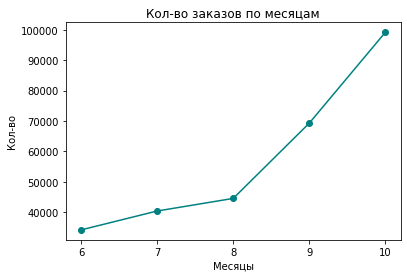

In [26]:
# посмотрим динамику заказов по месяцам
month_orders = filtered_df.groupby('month').agg(orders_cnt=('order_id', 'count')).reset_index()

# строим график
plt.figure(figsize=(10,5))
month_orders.plot(x='month', y='orders_cnt', legend=False, marker='o', color='teal')
plt.title('Кол-во заказов по месяцам')
plt.xlabel('Месяцы')
plt.ylabel('Кол-во')
plt.xticks(month_orders['month'])
plt.show()

Видим рост кол-ва заказов с июня и по октябрь вулючительно с ускорением после августа.

In [27]:
# посмотрим распределение заказов летом и осенью по типу мероприятия
summer_events = filtered_df[filtered_df['season'] == 'лето'].groupby('event_type_main').agg(orders_cnt=
                                        ('order_id', 'count')).reset_index().sort_values('orders_cnt', ascending=False)
autumn_events = filtered_df[filtered_df['season'] == 'осень'].groupby('event_type_main').agg(orders_cnt=
                                        ('order_id', 'count')).reset_index().sort_values('orders_cnt', ascending=False)

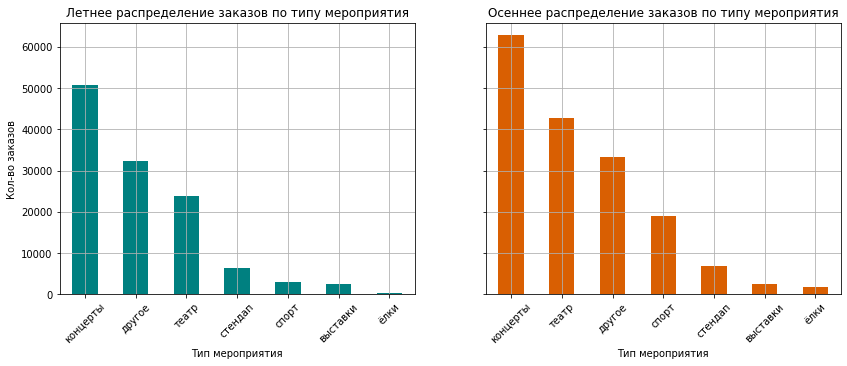

In [28]:
# построим графики
fig, axes = plt.subplots(1,2, figsize=(14,5), sharey=True)

summer_events.plot.bar(x='event_type_main', y='orders_cnt', ax=axes[0], color='teal', legend=False)
axes[0].set_title("Летнее распределение заказов по типу мероприятия")
axes[0].set_xlabel('Тип мероприятия')
axes[0].set_ylabel('Кол-во заказов')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid()

autumn_events.plot.bar(x='event_type_main', y='orders_cnt', ax=axes[1], color='#d95f02', legend=False)
axes[1].set_title("Осеннее распределение заказов по типу мероприятия")
axes[1].set_xlabel('Тип мероприятия')
axes[1].set_ylabel('Кол-во заказов')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid()

plt.show()

Видим, что осенью кол-во заказов по типам мероприятий выше, чем летом. Лидирует категория Концерты. Театр вышел на второе место, подвинув Другое, а Спорт подвинул Стендап с 4го места.

In [29]:
# добавим столбцы с долей в группировки по лету и осени
summer_events['event_type_share'] = summer_events['orders_cnt'] / summer_events['orders_cnt'].sum()
autumn_events['event_type_share'] = autumn_events['orders_cnt'] / autumn_events['orders_cnt'].sum()

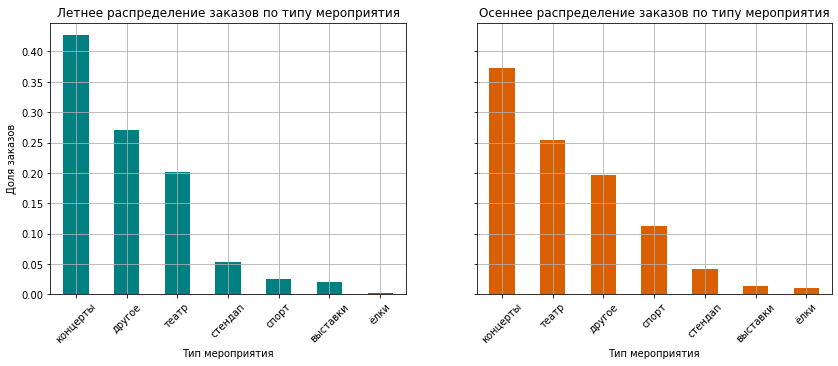

In [30]:
# построим эти же графики, но в долях
fig, axes = plt.subplots(1,2, figsize=(14,5), sharey=True)

summer_events.plot.bar(x='event_type_main', y='event_type_share', ax=axes[0], color='teal', legend=False)
axes[0].set_title("Летнее распределение заказов по типу мероприятия")
axes[0].set_xlabel('Тип мероприятия')
axes[0].set_ylabel('Доля заказов')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid()

autumn_events.plot.bar(x='event_type_main', y='event_type_share', ax=axes[1], color='#d95f02', legend=False)
axes[1].set_title("Осеннее распределение заказов по типу мероприятия")
axes[1].set_xlabel('Тип мероприятия')
axes[1].set_ylabel('Доля заказов')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid()


Видим, что доля заказов на концерты снизилась осенью по сравнению с летом, но эта категория по прежнему в лидерах, а доля билетов в театры и на спорт - выросла.

In [31]:
# посмотрим распределение заказов летом и осенью по типу мероприятия
summer_device = filtered_df[filtered_df['season'] == 'лето'].groupby('device_type_canonical').agg(orders_cnt=
                                        ('order_id', 'count')).reset_index().sort_values('orders_cnt', ascending=False)
autumn_device = filtered_df[filtered_df['season'] == 'осень'].groupby('device_type_canonical').agg(orders_cnt=
                                        ('order_id', 'count')).reset_index().sort_values('orders_cnt', ascending=False)
# добавим столбцы с долей заказов в категории от общего кол-ва заказов
summer_device['device_share'] = summer_device['orders_cnt'] / summer_device['orders_cnt'].sum()
autumn_device['device_share'] = autumn_device['orders_cnt'] / autumn_device['orders_cnt'].sum()

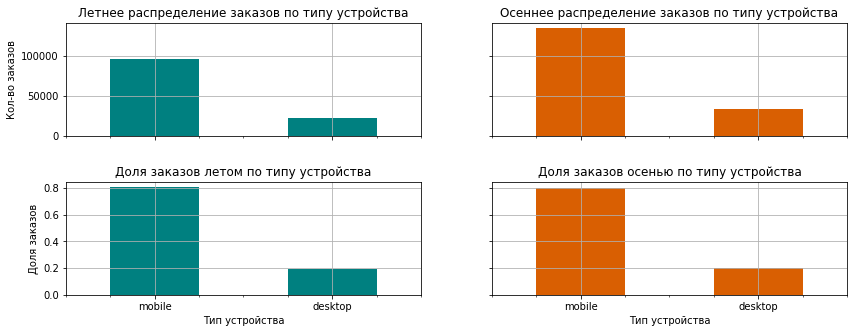

In [32]:
# строим графики
fig, axes = plt.subplots(2,2, figsize=(14,5), sharey='row', sharex=True)

summer_device.plot.bar(x='device_type_canonical', y='orders_cnt', ax=axes[0, 0], color='teal', legend=False)
axes[0,0].set_title("Летнее распределение заказов по типу устройства")
axes[0,0].set_ylabel('Кол-во заказов')
axes[0,0].grid()

autumn_device.plot.bar(x='device_type_canonical', y='orders_cnt', ax=axes[0,1], color='#d95f02', legend=False)
axes[0,1].set_title("Осеннее распределение заказов по типу устройства")
axes[0,1].grid()

summer_device.plot.bar(x='device_type_canonical', y='device_share', ax=axes[1, 0], color='teal', legend=False)
axes[1,0].set_title("Доля заказов летом по типу устройства")
axes[1,0].set_xlabel('Тип устройства')
axes[1,0].set_ylabel('Доля заказов')
axes[1,0].tick_params(axis='x', rotation=0)
axes[1,0].grid()

autumn_device.plot.bar(x='device_type_canonical', y='device_share', ax=axes[1,1], color='#d95f02', legend=False)
axes[1,1].set_title("Доля заказов осенью по типу устройства")
axes[1,1].set_xlabel('Тип устройства')
axes[1,1].tick_params(axis='x', rotation=0)
axes[1,1].grid()

fig.subplots_adjust(hspace=0.4)
plt.show()

Видим, что доли заказов летом и осенью по типу устройства одинаковые, а вот абсолютные значения осенью выросли.

In [33]:
# посмотрим распределение заказов летом и осенью по возрастному рейтингу
summer_age = filtered_df[filtered_df['season'] == 'лето'].groupby('age_limit').agg(orders_cnt=
                                        ('order_id', 'count')).reset_index().sort_values('age_limit')
autumn_age = filtered_df[filtered_df['season'] == 'осень'].groupby('age_limit').agg(orders_cnt=
                                        ('order_id', 'count')).reset_index().sort_values('age_limit')
# добавим столбцы с долей заказов в категории от общего кол-ва заказов
summer_age['age_share'] = summer_age['orders_cnt'] / summer_age['orders_cnt'].sum()
autumn_age['age_share'] = autumn_age['orders_cnt'] / autumn_age['orders_cnt'].sum()

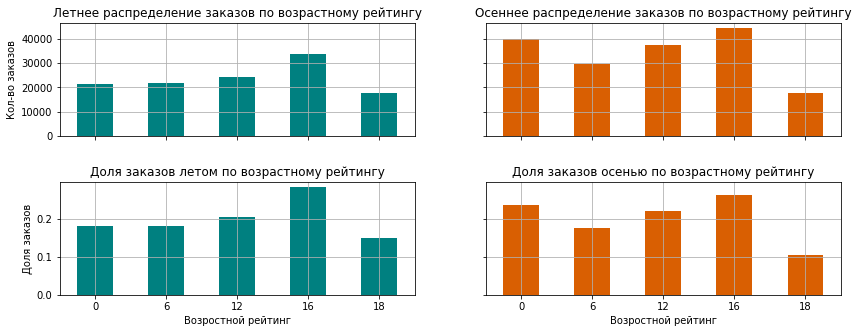

In [34]:
# строим графики
fig, axes = plt.subplots(2,2, figsize=(14,5), sharey='row', sharex=True)

summer_age.plot.bar(x='age_limit', y='orders_cnt', ax=axes[0, 0], color='teal', legend=False)
axes[0,0].set_title("Летнее распределение заказов по возрастному рейтингу")
axes[0,0].set_ylabel('Кол-во заказов')
axes[0,0].grid()

autumn_age.plot.bar(x='age_limit', y='orders_cnt', ax=axes[0,1], color='#d95f02', legend=False)
axes[0,1].set_title("Осеннее распределение заказов по возрастному рейтингу")
axes[0,1].grid()

summer_age.plot.bar(x='age_limit', y='age_share', ax=axes[1, 0], color='teal', legend=False)
axes[1,0].set_title("Доля заказов летом по возрастному рейтингу")
axes[1,0].set_xlabel('Возростной рейтинг')
axes[1,0].set_ylabel('Доля заказов')
axes[1,0].tick_params(axis='x', rotation=0)
axes[1,0].grid()

autumn_age.plot.bar(x='age_limit', y='age_share', ax=axes[1,1], color='#d95f02', legend=False)
axes[1,1].set_title("Доля заказов осенью по возрастному рейтингу")
axes[1,1].set_xlabel('Возростной рейтинг')
axes[1,1].tick_params(axis='x', rotation=0)
axes[1,1].grid()

fig.subplots_adjust(hspace=0.4)
plt.show()

Видим, что в абсолютных значениях осенью выросли заказы по всем возрастным рейтингам, кроме 18+. В долях 6+ осталось почти неизменной, выросли доли 0 и 12+, снизились доли 16+ и 18+.

Посмотрим, как менялась выручка с одного билета по месяцам.

<Figure size 720x360 with 0 Axes>

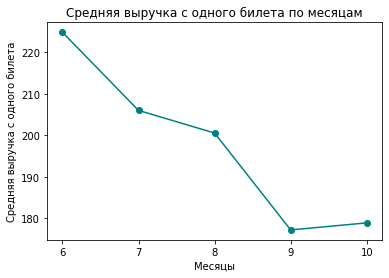

In [35]:
# сгруппируем по месяцу и посчитаем среднюю выручку с одного билета
ticket_month = filtered_df.groupby('month').agg(avg_ticket_renevue=('one_ticket_revenue_rub', 'mean')).reset_index()

# строим график
plt.figure(figsize=(10,5))
ticket_month.plot(x='month', y='avg_ticket_renevue', legend=False, marker='o', color='teal')
plt.title('Средняя выручка с одного билета по месяцам')
plt.xlabel('Месяцы')
plt.ylabel('Средняя выручка с одного билета')
plt.xticks(ticket_month['month'])
plt.show()

Видим, что средняя выручка с одного билета стабильно снижалась все лето и сентябрь, и только в октябре есть небольшой отскок (но не сравнимый с уровнем снижения).

Посмотрим ту же динамику, но уже по типам мероприятий.

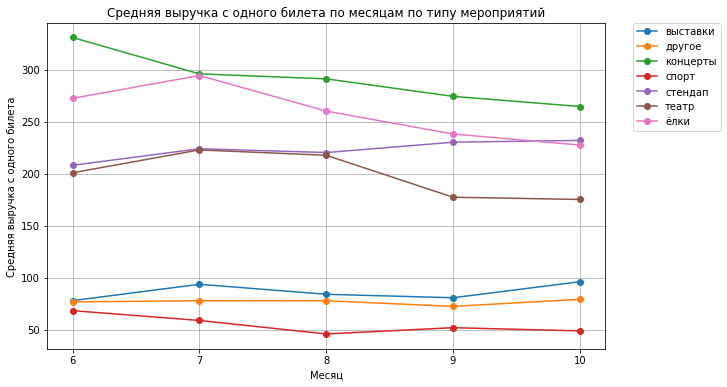

In [36]:
# сгруппируем по месяцу и по типу мероприятий и посчитаем среднюю выручку с одного билета
ticket_event_m = filtered_df.groupby(['event_type_main', 'month']).agg(avg_ticket_renevue=('one_ticket_revenue_rub', 
                                                                                           'mean')).reset_index()
# сделем сводную таблицу
pivot = ticket_event_m.pivot(index='month', columns='event_type_main', values='avg_ticket_renevue')

# строим график
pivot.plot(marker='o', figsize=(10,6))

plt.xlabel('Месяц')
plt.ylabel('Средняя выручка с одного билета')
plt.title('Средняя выручка с одного билета по месяцам по типу мероприятий')
plt.legend(title='Тип мероприятия')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.grid(True)
plt.xticks(pivot.index)
plt.show()

Видно, что выручка с одного билета распределилась по ценовым категориям: 
- до 100руб с билета - выставки, другое, спорт;
- от 150 до 250 - стендап и театр;
- от 250 и выше - концерты и елки.

Видим также общую тенденцию к снижению выручки в осенью (кроме стендапа и выставок).

Теперь посчитаем среднюю выручку с одного билет по типу мероприятия за весь период.

In [37]:
# сруппируем данные по типу мероприятия и посчитаем среднюю выручку с одного билета летом и осенью
mean_rev_summer = filtered_df[filtered_df['season'] == 'лето'].groupby(
    'event_type_main').agg(avg_ticket_renevue=('one_ticket_revenue_rub', 'mean')).reset_index()
mean_rev_autumn = filtered_df[filtered_df['season'] == 'осень'].groupby(
    'event_type_main').agg(avg_ticket_renevue=('one_ticket_revenue_rub', 'mean')).reset_index()

# соединим эти таблицы
comparison = pd.merge(mean_rev_summer, mean_rev_autumn, on='event_type_main', suffixes=('_summer', '_autumn'))
# добавим столбец с относительным измененеием выручки осенью по сравнению с летом
comparison['relative_change'] = (comparison['avg_ticket_renevue_autumn'] - comparison['avg_ticket_renevue_summer']
                                ) / comparison['avg_ticket_renevue_summer']
comparison

,event_type_main,avg_ticket_renevue_summer,avg_ticket_renevue_autumn,relative_change
0,выставки,86.388607,90.603609,0.048791
1,другое,77.395011,76.069735,-0.017124
2,концерты,304.805591,268.376406,-0.119516
3,спорт,50.744650,49.980039,-0.015068
4,стендап,218.518107,231.124973,0.057693
5,театр,214.185553,175.978105,-0.178385
6,ёлки,271.436177,229.564211,-0.154261


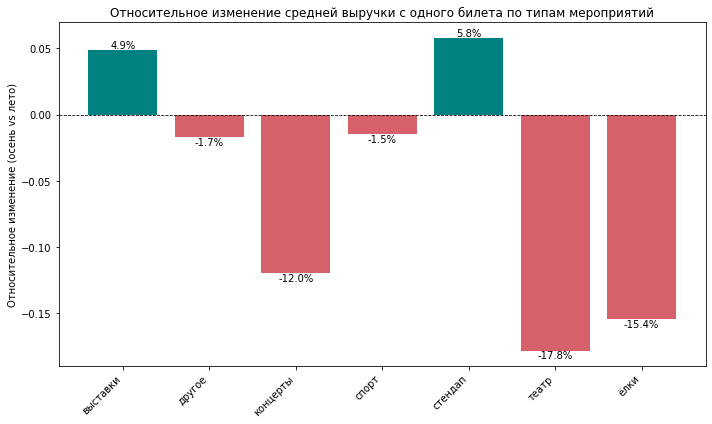

In [38]:
# строим график
plt.figure(figsize=(10, 6))
# задаем цвета взависимости от знака
colors = ['teal' if val >= 0 else '#d6616b' for val in comparison['relative_change']]

bars = plt.bar(comparison['event_type_main'], comparison['relative_change'], color=colors)
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Относительное изменение (осень vs лето)')
plt.title('Относительное изменение средней выручки с одного билета по типам мероприятий')

# подписи процентов над столбцами
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.1%}', ha='center', va='bottom' if height >= 0 else 'top')

plt.tight_layout()
plt.show()

Как и на линейном графике видно, что за время наблюдений средняя выручка с одного билета осенью снизилась относительно лета почти по всем типам мероприятий, кроме выставок и стендапа. Самое сильное падение выручки у театров. А самый большоей рост у стендапа.

**Промежуточные выводы**

Заказы по типам мероприятий и устройствам
- Абсолютное количество заказов осенью выросло по сравнению с летом.
- По типам мероприятий осенью наблюдается увеличение общего объема заказов с июня по октябрь, с ускорением после августа.
- Лидирует категория «Концерты», которая сохраняет свои позиции.
- «Театр» поднялся на второе место, сместив категорию «Другое».
- «Спорт» усилился, вытеснив «Стендап» с четвёртого места.
- Доли заказов по типам мероприятий показывают уменьшение у концертов и рост у театра и спорта осенью.
- Доли заказов по типу устройства остались почти неизменными летом и осенью, при этом абсолютные значения заказов по устройствам выросли осенью.

Заказы по возрастным рейтингам
- В абсолютных значениях осенью выросли заказы по всем возрастным категориям, кроме 18+.
- В относительных долях категории 6+ осталась почти неизменной.
- Доли 0 и 12+ выросли.
- Доли 16+ и 18+ снизились осенью.

Средняя выручка с билета
- Средняя выручка с одного билета стабильно снижалась всё лето и сентябрь, с незначительным отскоком в октябре, который не компенсирует снижение.
- Выручка с одного билета распределилась по ценовым категориям:
    - До 100 руб: выставки, другое, спорт.
    - От 150 до 250 руб: стендап и театр.
    - От 250 руб и выше: концерты и ёлки.
- Общая тенденция — снижение выручки осенью, исключение составляют стендап и выставки.
- Самое сильное падение выручки наблюдается у театров.
- Самый значимый рост выручки зафиксирован у стендапа.

[к содержанию](#label_00)

---

<a id="label_3_2"></a>
#### 3.2 Осенняя активность пользователей.

Изучим активность пользователей осенью 2024г. У нас есть данные только за 2 месяца осени - сентябрь и октябрь.

**Проанализируем динамику изменений по дням для:**
- общего числа заказов;
- количества активных пользователей DAU;
- среднего числа заказов на одного пользователя;
- средней стоимости одного билета.

In [39]:
# создадим сводную таблицу
pivot_df = pd.pivot_table(
    filtered_df,
    index='created_dt_msk',
    values=['order_id', 'user_id', 'one_ticket_revenue_rub'],
    aggfunc={'order_id': 'count', 'user_id': pd.Series.nunique, 'one_ticket_revenue_rub': 'mean'}
).rename(columns={'order_id': 'orders_count', 'user_id': 'unique_users', 'one_ticket_revenue_rub': 'avg_revenue_per_ticket'})

# добавляем столбец с заказами на одного пользователя
pivot_df['orders_per_user'] = pivot_df['orders_count'] / pivot_df['unique_users']
# отфильтруем данные по двум осенним месяцам
pivot_df = pivot_df[(pivot_df.index >= '2024-09-01') & (pivot_df.index <= '2024-10-31')]
pivot_df

,avg_revenue_per_ticket,orders_count,unique_users,orders_per_user
created_dt_msk,,,,
2024-09-01,200.168708,1327,564,2.352837
2024-09-02,189.464640,1380,574,2.404181
2024-09-03,80.350151,5113,778,6.571979
2024-09-04,178.077235,1772,685,2.586861
2024-09-05,189.763046,1940,739,2.625169
...,...,...,...,...
2024-10-27,186.968329,2849,1034,2.755319
2024-10-28,170.542890,2837,985,2.880203
2024-10-29,177.474151,2834,998,2.839679


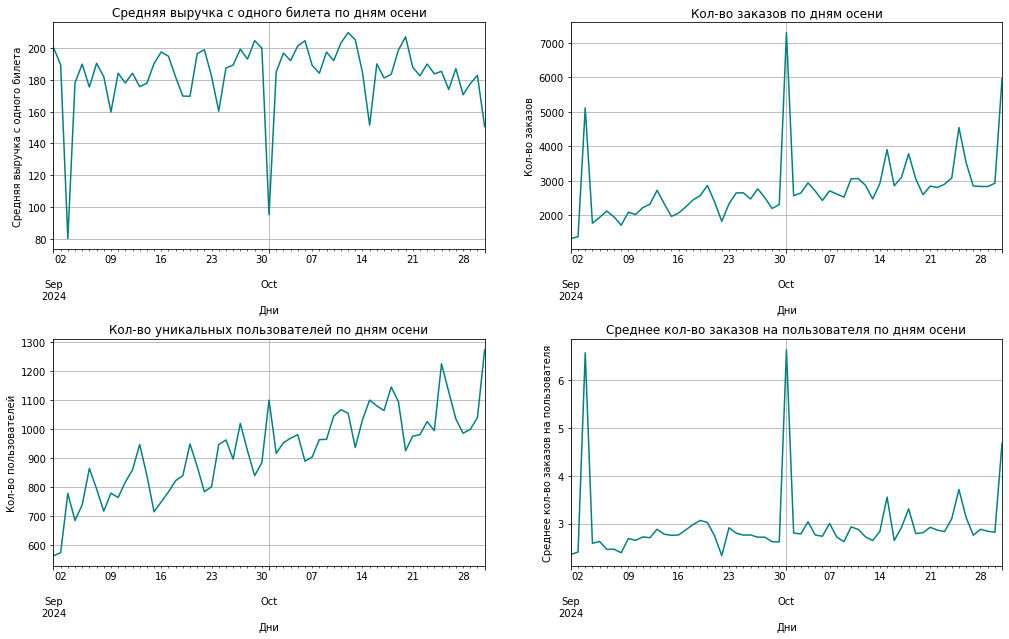

In [40]:
# строим графики
fig, axes = plt.subplots(2,2, figsize=(17,10))

pivot_df.plot.line(y='avg_revenue_per_ticket', ax=axes[0, 0], color='teal', legend=False)
axes[0,0].set_title("Средняя выручка с одного билета по дням осени")
axes[0,0].set_ylabel('Средняя выручка с одного билета')
axes[0,0].set_xlabel('Дни')
axes[0,0].grid()

pivot_df.plot.line(y='orders_count', ax=axes[0,1], color='teal', legend=False)
axes[0,1].set_title("Кол-во заказов по дням осени")
axes[0,1].set_ylabel('Кол-во заказов')
axes[0,1].set_xlabel('Дни')
axes[0,1].grid()

pivot_df.plot.line(y='unique_users', ax=axes[1, 0], color='teal', legend=False)
axes[1,0].set_title("Кол-во уникальных пользователей по дням осени")
axes[1,0].set_xlabel('Дни')
axes[1,0].set_ylabel('Кол-во пользователей')
axes[1,0].grid()

pivot_df.plot.line(y='orders_per_user', ax=axes[1,1], color='teal', legend=False)
axes[1,1].set_title("Среднее кол-во заказов на пользователя по дням осени")
axes[1,1].set_xlabel('Дни')
axes[1,1].set_ylabel('Среднее кол-во заказов на пользователя')
axes[1,1].grid()

fig.subplots_adjust(hspace=0.4)
plt.show()

Видим рост DAU с начала сентября и по конец октября.

Средняя выручка с одного заказа стабильна (движется вбок), есть провалы в начале сентября, в начале и в конце октября (видимо были акции). В эти же дни видим всплеск покупательской активности - резко выросло кол-во заказов и среднее кол-во заказов на пользователя в эти дни. Кол-во заказов и среднее кол-во заказов на пользователя растут за период этих двух месяцев, причем кол-во заказов растет чуть быстрее, чем кол-во заказов на одного пользователя.

[к содержанию](#label_00)


Посмотрим активность пользователей по дням недели осенью.

In [41]:
# отфильтруем данные по двум осенним месяцам
filtered_autumn_df = filtered_df[(filtered_df['created_dt_msk'] >= '2024-09-01') & (filtered_df['created_dt_msk'] 
                                                                                    <= '2024-10-31')]
# сгруппируем по дате и посчитаем кол-во уникальных пользователей в день, кол-во заказов и сумму выручки
autumn_day = filtered_autumn_df.groupby('created_dt_msk').agg(
                                                            unique_users=('user_id', 'nunique'),
                                                            orders=('order_id', 'count'),
                                                            day_revenue=('revenue_rub','sum')).reset_index()
# добавим столбец с номером недели
autumn_day['num_week_day'] = autumn_day['created_dt_msk'].dt.isocalendar().day
# создадим словарь с названиями дней недели
week = {1:'Пон', 2:'Вт', 3:'Ср', 4:'Чт', 5:'Пт', 6:'Сб', 7:'Вс'}
# добавим столбец с названиями дней недели
autumn_day['day_name'] = autumn_day['num_week_day'].map(week)
# сгруппируем по дню недели и посчитаем среднее кол-во заказов, пользователей и среднюю выручку 
autumn_week_day = autumn_day.groupby(['num_week_day', 'day_name']).agg(
                                                                        avg_unique_users=('unique_users', 'mean'),
                                                                        avg_orders=('orders', 'mean'),
                                                                        avg_revenue=('day_revenue', 'mean')).reset_index()
# добавим столбец средней выручки в млн
autumn_week_day['avg_revenue_mln'] = autumn_week_day['avg_revenue'] / 1e6
autumn_week_day

,num_week_day,day_name,avg_unique_users,avg_orders,avg_revenue,avg_revenue_mln
0,1,Пон,853.444444,2389.333333,1.193856e+06,1.193856
1,2,Вт,934.444444,3497.888889,1.352005e+06,1.352005
2,3,Ср,923.222222,2541.666667,1.279046e+06,1.279046
3,4,Чт,962.000000,3016.888889,1.444409e+06,1.444409
4,5,Пт,1022.375000,3101.500000,1.575114e+06,1.575114
5,6,Сб,960.750000,2667.125000,1.411279e+06,1.411279
6,7,Вс,822.555556,2153.888889,1.165383e+06,1.165383


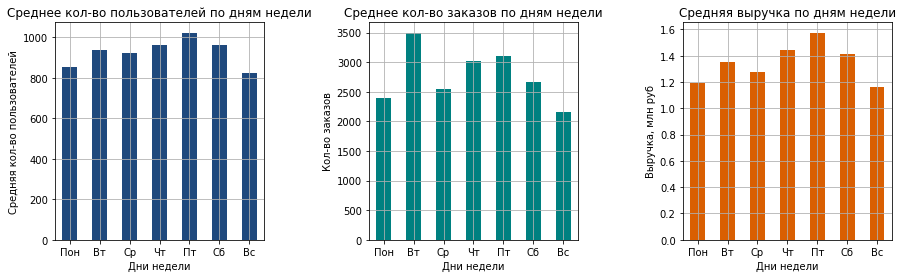

In [42]:
# построим графики
fig, axes = plt.subplots(1,3, figsize=(15,4))

# график кол-ва пользователей
autumn_week_day.plot.bar(x='day_name', y='avg_unique_users', ax=axes[0], color='#1f497d', legend=False)
axes[0].set_title("Среднее кол-во пользователей по дням недели")
axes[0].set_ylabel('Средняя кол-во пользователей')
axes[0].set_xlabel('Дни недели')
axes[0].grid()

# график кол-ва заказов
autumn_week_day.plot.bar(x='day_name', y='avg_orders', ax=axes[1], color='teal', legend=False)
axes[1].set_title("Среднее кол-во заказов по дням недели")
axes[1].set_ylabel('Кол-во заказов')
axes[1].set_xlabel('Дни недели')
axes[1].grid()

# график выручки
autumn_week_day.plot.bar(x='day_name', y='avg_revenue_mln', ax=axes[2], color='#d95f02', legend=False)
axes[2].set_title("Средняя выручка по дням недели")
axes[2].set_ylabel('Выручка, млн руб')
axes[2].set_xlabel('Дни недели')
axes[2].grid()

# поворачиваем названия дней недели
for ax in axes:
    ax.tick_params(axis='x', labelrotation=0)

fig.subplots_adjust(wspace=0.5)
plt.show()

Активность пользователей по дням недели:
- Среднее кол-во пользователей растет с понедельника по пятницу (максимум), небольшой всплеск во вторник, на выходные идет спад.
- Среднее кол-во заказов тоже растет с понедельника по пятрицу, но есть пик во вторник (максимум). В выходные спад.
- Средняя выручка также растет с понедельника по пятницу (максимум). Есть небольшой всплеск во вторник, но не такой высокий, как ожидалось по пику заказов - видимо были акции и цена была ниже.

По всей видимости акции запускают во вторник, т.к. в этот день наблюдается максимум кол-ва заказов, при этом кол-во пользователей и выручка хоть и выше понедельника, но ниже пятничного максимума.


---

<a id="label_3_3"></a>
#### 3.3 Популярные события и партнёры.

- Для каждого **региона** посчитаем уникальное количество мероприятий и общее число заказов. Посмотрим, в каких регионах предлагается наибольшее разнообразие мероприятий?
- Для каждого **билетного партнёра** посчитаем общее число уникальных мероприятий, обработанных заказов и суммарную выручку с заказов билетов. Выделим наиболее активных партнёров.

In [43]:
# сгруппируем данные по регионам, посчитаем кол-во уникальных мероприятий и общее число заказов
region_df = filtered_df.groupby('region_name').agg(unique_events=
                                                  ('event_name', 'nunique'),
                                                  order_cnt=
                                                  ('order_id', 'count')).reset_index().sort_values('unique_events',
                                                                                                   ascending=False)
# добавим столбецы с долями уникальных событий и числа заказов
region_df['unique_events_share'] = region_df['unique_events'] / region_df['unique_events'].sum()
region_df['order_cnt_share'] = region_df['order_cnt'] / region_df['order_cnt'].sum()
region_df

,region_name,unique_events,order_cnt,unique_events_share,order_cnt_share
23,Каменевский регион,4748,89649,0.247808,0.311712
60,Североярская область,3196,43628,0.166806,0.151696
57,Светополянский округ,997,7502,0.052035,0.026085
77,Широковская область,992,16164,0.051775,0.056203
52,Речиновская область,653,6266,0.034081,0.021787
...,...,...,...,...,...
68,Теплоозёрский округ,2,7,0.000104,0.000024
66,Сосноводолинская область,2,10,0.000104,0.000035
33,Лесноярский край,2,19,0.000104,0.000066
56,Светолесский край,2,24,0.000104,0.000083


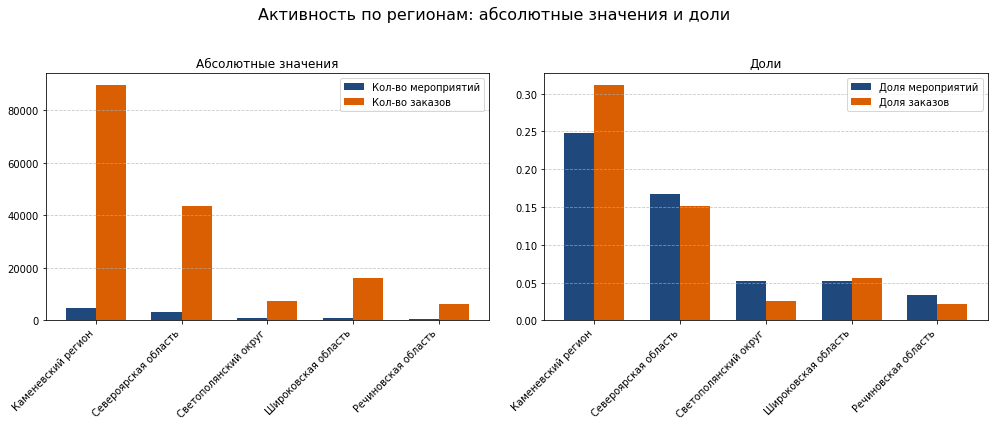

In [44]:
top_5_regions = region_df.head(5)

x = np.arange(len(top_5_regions['region_name']))
width = 0.35

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Абсолютные значения
bar1_1 = ax1.bar(x - width/2, top_5_regions['unique_events'], width, label='Кол-во мероприятий', color='#1f497d')
bar1_2 = ax1.bar(x + width/2, top_5_regions['order_cnt'], width, label='Кол-во заказов', color='#d95f02')
ax1.set_xticks(x)
ax1.set_xticklabels(top_5_regions['region_name'], rotation=45, ha='right')
ax1.set_title('Абсолютные значения')
ax1.grid(axis='y', linestyle='--', alpha=0.7)
ax1.legend()

# Доли
bar2_1 = ax2.bar(x - width/2, top_5_regions['unique_events_share'], width, label='Доля мероприятий', color='#1f497d')
bar2_2 = ax2.bar(x + width/2, top_5_regions['order_cnt_share'], width, label='Доля заказов', color='#d95f02')
ax2.set_xticks(x)
ax2.set_xticklabels(top_5_regions['region_name'], rotation=45, ha='right')
ax2.set_title('Доли')
ax2.grid(axis='y', linestyle='--', alpha=0.7)
ax2.legend()

plt.suptitle('Активность по регионам: абсолютные значения и доли', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

Больше всего уникальных мероприятий проводилось в двух районах:
- Каменевский регион:
    - 4 748 мероприятий (25% от общего числа мероприятий)
    - 89 649 заказов (31% от общего числа заказов)
- Североярская область:
    - 3 196 мероприятий (17% от общего числа мероприятий)
    - 43 628 заказов (15% от общего числа заказов)

In [45]:
# сгруппируем данные по партнерам и посчитаем число уникальных мероприятий, число заказов и общую выручку
service_df = filtered_df.groupby('service_name').agg(unique_events=
                                                  ('event_name', 'nunique'),
                                                  order_cnt=
                                                  ('order_id', 'count'),
                                                   total_revenue=
                                                    ('revenue_rub', 'sum')).reset_index().sort_values('unique_events',
                                                                                                   ascending=False)
# добавим столбцы с долями числа мероприятий, часла заказов и обей выручки
service_df['unique_events_share'] = service_df['unique_events'] / service_df['unique_events'].sum()
service_df['order_cnt_share'] = service_df['order_cnt'] / service_df['order_cnt'].sum()
service_df['revenue_share'] = service_df['total_revenue'] / service_df['total_revenue'].sum()
service_df

,service_name,unique_events,order_cnt,total_revenue,unique_events_share,order_cnt_share,revenue_share
21,Лови билет!,3856,40802,1.667497e+07,0.194286,0.141870,1.118303e-01
3,Билеты без проблем,3156,62738,2.420158e+07,0.159016,0.218142,1.623074e-01
5,Билеты в руки,2942,40279,1.319228e+07,0.148234,0.140051,8.847375e-02
25,Облачко,1762,26402,1.858861e+07,0.088779,0.091800,1.246642e-01
22,Лучшие билеты,1514,17734,2.720993e+06,0.076284,0.061662,1.824828e-02
24,Мой билет,1029,34417,2.201831e+07,0.051847,0.119669,1.476653e-01
30,Тебе билет!,925,5191,2.962344e+06,0.046607,0.018049,1.986690e-02
26,Прачечная,874,10222,4.746811e+06,0.044037,0.035542,3.183439e-02
8,Весь в билетах,688,16425,1.653323e+07,0.034665,0.057110,1.108798e-01
35,Яблоко,612,5004,3.868337e+06,0.030836,0.017399,2.594292e-02


In [46]:
top_5_services = service_df.head(5)

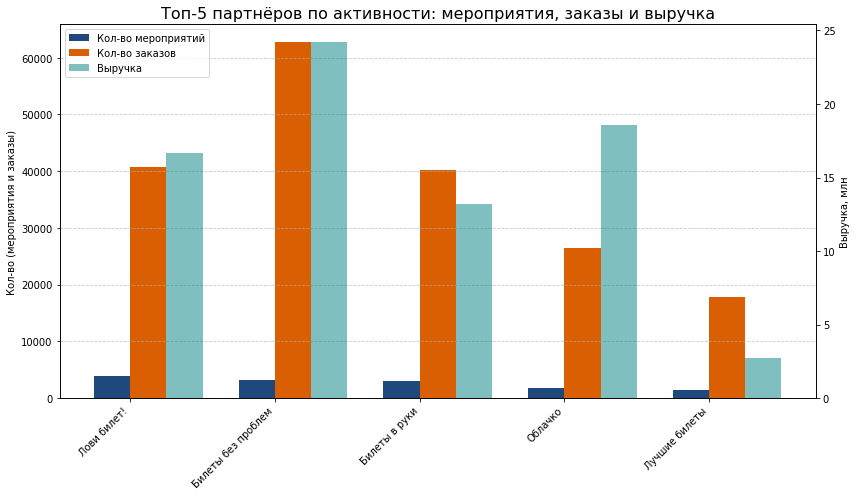

In [47]:
x = np.arange(len(top_5_services['service_name']))
width = 0.25  # ширина столбцов

fig, ax1 = plt.subplots(figsize=(12,7))

# Столбцы для unique_events, order_cnt (активность)
bar1 = ax1.bar(x - width/2, top_5_services['unique_events'], width, label='Кол-во мероприятий', color='#1f497d')
bar2 = ax1.bar(x + width/2, top_5_services['order_cnt'], width, label='Кол-во заказов', color='#d95f02')

ax1.set_ylabel('Кол-во (мероприятия и заказы)')
ax1.set_xticks(x)
ax1.set_xticklabels(top_5_services['service_name'], rotation=45, ha='right')
ax1.grid(axis='y', linestyle='--', alpha=0.7)

ax2 = ax1.twinx()
bar3 = ax2.bar(x + width*1.5, top_5_services['total_revenue'] / 1e6, width, alpha=0.5, label='Выручка', color='teal')
ax2.set_ylabel('Выручка, млн')

ax1.legend([bar1, bar2, bar3], ['Кол-во мероприятий', 'Кол-во заказов', 'Выручка'], loc='upper left')

plt.title('Топ-5 партнёров по активности: мероприятия, заказы и выручка', fontsize=16)
plt.tight_layout()
plt.show()

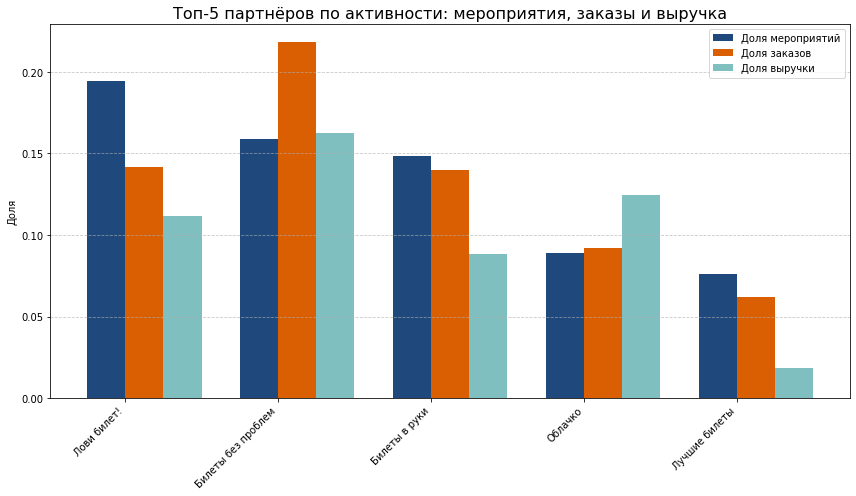

In [48]:
x = np.arange(len(top_5_services['service_name']))
width = 0.25  # ширина столбцов

fig, ax1 = plt.subplots(figsize=(12,7))

# Столбцы для unique_events, order_cnt (активность)
bar1 = ax1.bar(x - width/2, top_5_services['unique_events_share'], width, label='Доля мероприятий', color='#1f497d')
bar2 = ax1.bar(x + width/2, top_5_services['order_cnt_share'], width, label='Доля заказов', color='#d95f02')

ax1.set_ylabel('Доля (мероприятия и заказы)')
ax1.set_xticks(x)
ax1.set_xticklabels(top_5_services['service_name'], rotation=45, ha='right')
ax1.grid(axis='y', linestyle='--', alpha=0.7)

bar3 = ax1.bar(x + width*1.5, top_5_services['revenue_share'], width, alpha=0.5, label='Доля выручки', color='teal')
ax1.set_ylabel('Доля')

ax1.legend([bar1, bar2, bar3], ['Доля мероприятий', 'Доля заказов', 'Доля выручки'], loc='upper right')

plt.title('Топ-5 партнёров по активности: мероприятия, заказы и выручка', fontsize=16)
plt.tight_layout()
plt.show()

Самый активный по разнообразию мероприятий партнер - "Лови билет!" - 3 856 уникальных мероприятий за исследуемый период (19.4% всех мероприятий). При этом кол-во заказов и выручка у него меньше, чему у второго по активности партнера "Билеты без проблем" - у него самое большое кол-во заказов 62 738 (21,8% всех заказов) и самая большая выручка 24,2 млн руб. (16,2% всей выручки).

**Промежуточные выводы**
- Два региона — Каменевский и Североярская область — концентрируют основную часть уникальных мероприятий и заказов. Каменевский регион занимает лидирующую позицию с четвертью всех мероприятий (25%) и почти третью часть заказов (31%), Североярская область — вторая по активности с 17% мероприятий и 15% заказов. Это указывает на наличие крупных и активных центров событий в данных регионах.

- Среди партнёров по продажам билетов лидер по количеству уникальных мероприятий — "Лови билет!" с 19,4% событий, но при этом уступающий по объёму заказов и выручке. "Билеты без проблем" занимают второе место по количеству мероприятий, но опережают по заказам (21,8%) и прибыли (16,2%). Это может говорить о более эффективной монетизации и конверсии у второго партнёра, несмотря на меньшую разнообразность мероприятий.

- Разрыв между количеством проведённых мероприятий и полученной выручкой свидетельствует об отличиях в качестве или стоимости билетов, а также в конверсионной эффективности партнеров.

- В совокупности данные показывают концентрацию активности и выручки в нескольких ведущих регионах и партнёрах, что характерно для зрелого и сегментированного рынка, где ключевые игроки удерживают большую долю.

- Такие выводы позволяют сориентироваться в фокусе дальнейших стратегий развития — например, усиливать работу в топ-регионах и с наиболее прибыльными партнёрами, а также анализировать причины высокой конверсии у некоторых игроков для тиражирования успешных практик.

**Итог**: концентрация активности и прибыли в определённых регионах и партнёрах указывает на значимые центры влияния на рынке билетов и мероприятий, важные для бизнес-анализа и планирования.

[к содержанию](#label_00)

---

<a id="label_4"></a>
### 4. Статистический анализ данных.

Коллеги из продуктового отдела хотят отдельно проверить несколько гипотез относительно активности пользователей мобильных и стационарных устройств. Нужно проверить две гипотезы, которые предполагают большую активность пользователей мобильных устройств:
- **Среднее количество заказов** на одного пользователя мобильного приложения выше по сравнению с пользователями стационарных устройств.
- **Среднее время между заказами** пользователей мобильных приложений выше по сравнению с пользователями стационарных устройств.

Гипотезы должны быть проверены только на осенних данных.

In [49]:
filtered_df['device_type_canonical'].unique()

array(['mobile', 'desktop'], dtype=object)

In [50]:
# отфильтруем данные по осени
autumn = filtered_df[filtered_df['season'] == 'осень']
# разделим данные на два датафрейма: на стационарных и мобильных устройствах
desktop = autumn[autumn['device_type_canonical'] == 'desktop']
mobile = autumn[autumn['device_type_canonical'] == 'mobile']
# сгруппируем эти датафреймы по пользователям и посчитаем для них кол-во заказов
desktop_users = desktop.groupby('user_id').agg(order_cnt=
                                                      ('order_id', 'count')).reset_index()
mobile_users = mobile.groupby('user_id').agg(order_cnt=
                                                    ('order_id', 'count')).reset_index()
print(f'В таблице пользователей десктопров кол-во строк: {desktop_users.shape[0]}')
print(f'В таблице пользователей мобильных устройств кол-во строк: {mobile_users.shape[0]}')

В таблице пользователей десктопров кол-во строк: 4866
В таблице пользователей мобильных устройств кол-во строк: 14187


Прежде, чем проводить тесты, нужно исследовать группы на:
- пропуски и дубликаты
- аномалии и выборсы
- пересечеия

In [51]:
# проверим на пропуски 
tmp = desktop_users.copy()            # Делаем копию текущего датасета
missing_stats = pd.DataFrame({'Кол-во пропусков': tmp.isnull().sum(),
                              'Доля пропусков': tmp.isnull().mean().round(4)})
missing_stats = missing_stats[missing_stats['Кол-во пропусков'] > 0]
print('В таблице пользователей десктопов:')
missing_stats.style.background_gradient(cmap='Greens') if not missing_stats.empty else "Пропусков в данных нет"

В таблице пользователей десктопов:


'Пропусков в данных нет'

In [52]:
tmp = mobile_users.copy()            # Делаем копию текущего датасета
missing_stats = pd.DataFrame({'Кол-во пропусков': tmp.isnull().sum(),
                              'Доля пропусков': tmp.isnull().mean().round(4)})
missing_stats = missing_stats[missing_stats['Кол-во пропусков'] > 0]
print('В таблице пользователей мобильных устройств:')
missing_stats.style.background_gradient(cmap='Greens') if not missing_stats.empty else "Пропусков в данных нет"

В таблице пользователей мобильных устройств:


'Пропусков в данных нет'

In [53]:
# проверим на дубликаты
dupl_des = desktop_users.duplicated().sum()
if dupl_des == 0:
    print('Дубликатов пользователей десктопов нет.')
else: 
    print(f'Найдено {dupl_des} дубликатов среди пользователей десктопов.')

Дубликатов пользователей десктопов нет.


In [54]:
dupl_mob = mobile_users.duplicated().sum()
if dupl_mob == 0:
    print('Дубликатов пользователей мобильных устройств нет.')
else: 
    print(f'Найдено {dupl_mob} дубликатов среди пользователей мобильных устройств.')

Дубликатов пользователей мобильных устройств нет.


In [55]:
# проверим выборки на пересечение
group_a = set(desktop_users['user_id'])
group_b = set(mobile_users['user_id'])
intersection = group_a & group_b
if intersection:
    print(f'Пересечения есть, кол-во: {len(intersection)}')
else:
    print('Пересечений нет')
    

Пересечения есть, кол-во: 3248


Слишком много пересечений, удалим их из обоих выборок.

In [56]:
desktop_users_filt = desktop_users.loc[~desktop_users['user_id'].isin(intersection)]
mobile_users_filt = mobile_users.loc[~mobile_users['user_id'].isin(intersection)]
print(f'В таблице пользователей десктопров осталось строк: {desktop_users_filt.shape[0]}')
print(f'В таблице пользователей мобильных устройств осталось строк: {mobile_users_filt.shape[0]}')

В таблице пользователей десктопров осталось строк: 1618
В таблице пользователей мобильных устройств осталось строк: 10939


In [57]:
# посмотрим, как распределены статистики в этих выборках
display(desktop_users_filt['order_cnt'].describe())
display(mobile_users_filt['order_cnt'].describe())

count    1618.000000
mean        1.972188
std         3.075805
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max        56.000000
Name: order_cnt, dtype: float64

count    10939.000000
mean         2.858945
std          4.097207
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max        123.000000
Name: order_cnt, dtype: float64

Стандартные отклонения (следовательно и дисперсии) у выборок сильно отличаются, выборки не одинаковые по кол-ву. Для проверки гипотезы о среднем кол-ве заказов на пользователя в этом случае подойдет t-тест Уэлча.

Сформулируем гипотезы:
- $H_{0}$ - **Среднее кол-во заказов** у пользователей десктопов и мобильных устройств не различается ($\mu_{d}=\mu_{m}$)
- $H_{1}$ - **Среднее кол-во заказов** у пользователей мобильных устройств выше, чем у пользователей десктопов ($\mu_{m}>\mu_{d}$)

In [58]:
# считаем тест Уэлча
grp_a = desktop_users_filt['order_cnt']
grp_b = mobile_users_filt['order_cnt']

result = ttest_ind(grp_b, grp_a, 
                  alternative='greater', # проверяем гипотезу (𝜇_𝑚>𝜇_𝑑)
                  equal_var=False) # включаем тест Уэлча

print(f't-статистика: {round(result.statistic, 4)}')
print(f'p-value: {result.pvalue}')

# Интерпретация:
alpha = 0.05 # уровень значимости
if result.pvalue < alpha:
    print('Отвергаем нулевую гипотезу. Есть статистические доказательства, что среднее кол-во заказов у пользователей мобильных устройств выше.')
else:
    print('Не отвергаем нулевую гипотезу. Статистических доказательств того, среднее кол-во заказов у пользователей мобильных устройств выше, нет.')

t-статистика: 10.3211
p-value: 8.515664394767323e-25
Отвергаем нулевую гипотезу. Есть статистические доказательства, что среднее кол-во заказов у пользователей мобильных устройств выше.


p-значение получилось очень маленьким, что дает нам статистически значимое доказательство гипотезы о том, что среднее кол-во заказов у пользователей мобильных устройств выше, чем у пользователей десктопов.

Это отличие видно было и из расчета среднего выше:
- 1,97 у пользователей десктопов
- 2,86 у пользователей мобильных устройств.

Теперь приступим к анализу данных для проверки второй гипотезы о среднем времени между заказами пользователей мобильных устройств и десктопов.

In [59]:
# посчитаем у пользователей десктопов и мобильных устройств среднее время между заказами
desktops_days = desktop.groupby('user_id').agg(avg_days=('days_since_prev', 'mean')).reset_index()
mobile_days = mobile.groupby('user_id').agg(avg_days=('days_since_prev', 'mean')).reset_index()
# удалим пропуски в столбце days_since_prev
desktops_days = desktops_days.dropna(subset=['avg_days'])
mobile_days = mobile_days.dropna(subset=['avg_days'])
# удалим пересекающихся пользователей (это те же, что и в выборках предыдущей гипотезы)
desktops_days_filt = desktops_days.loc[~desktops_days['user_id'].isin(intersection)]
mobile_days_filt = mobile_days.loc[~mobile_days['user_id'].isin(intersection)]
print(f'В таблице пользователей десктопров осталось строк: {desktops_days_filt.shape[0]}')
print(f'В таблице пользователей мобильных устройств осталось строк: {mobile_days_filt.shape[0]}')
# выведем статистики по этим выборкам
display(desktops_days_filt.describe())
display(mobile_days_filt.describe())

В таблице пользователей десктопров осталось строк: 894
В таблице пользователей мобильных устройств осталось строк: 7053


,avg_days
count,894.000000
mean,31.359261
std,36.562824
min,0.000000
25%,0.000000
50%,16.000000
75%,53.000000
max,146.000000


,avg_days
count,7053.000000
mean,25.231760
std,30.191755
min,0.000000
25%,2.851852
50%,14.000000
75%,36.000000
max,148.000000


Стандартное отклонение среднего времени между заказами у пользователей десктопов 36,56, а у пользователей мобильных устройств - 30,19 (21% разницы). Кол-ва пользователей в выборках различается почти в 8 раз. Для проверки гипотезы о среднем времени между заказами в этом случае тоже подойдет тест Уэлча.

Сформулируем гипотезы:
- $H_{0}$ - **Среднее время между заказами** у пользователей десктопов и мобильных устройств не различается ($\mu_{d}=\mu_{m}$)
- $H_{1}$ - **Среднее время между заказами** у пользователей мобильных устройств выше, чем у пользователей десктопов ($\mu_{m}>\mu_{d}$)

In [60]:
## считаем тест Уэлча
grp_d = desktops_days_filt['avg_days']
grp_m = mobile_days_filt['avg_days']

result = ttest_ind(grp_m, grp_d, 
                  alternative='greater', # проверяем гипотезу (𝜇_𝑚>𝜇_𝑑)
                  equal_var=False) # включаем тест Уэлча

print(f't-статистика: {round(result.statistic, 4)}')
print(f'p-value: {result.pvalue}')

# Интерпретация:
alpha = 0.05 # уровень значимости
if result.pvalue < alpha:
    print('Отвергаем нулевую гипотезу. Есть статистические доказательства, что среднее время между заказами у пользователей мобильных устройств выше.')
else:
    print('Не отвергаем нулевую гипотезу. Статистических доказательств того, среднее время между заказами у пользователей мобильных устройств выше, нет.')

t-статистика: -4.8074
p-value: 0.9999991244565929
Не отвергаем нулевую гипотезу. Статистических доказательств того, среднее время между заказами у пользователей мобильных устройств выше, нет.


p-значение почти 1, нет статистически значемых оснований отвергать нулевую гипотезу.

**Промежуточные выводы**

- Предположение, что **среднее кол-во заказов** у пользователей мобильных устройств выше, чем у пользователей десктопов, статистически подтвердилось.

- Предложение, что **среднее время мезду заказами** у пользователей мобильных устройств выше, чему у пользователей десктопов, статистически не подтвердилось.

[к содержанию](#label_00)

---

<a id="label_5"></a>
### 5. Общий вывод и рекомендации.

#### Информация о данных.

Были загружены три таблицы:

- `order_df` - таблица с заказами и выручкой
- `event_df` - таблица с событиями, городами и регионами
- `tenge_df` - таблица с курсом казахской тенге

В загруженных таблицах пропуски были только в таблице с заказами в столбце с кол-вом дней между заказами (у пользователей, у которых всего один заказ, в этом столбце пропуск, что очевидно). Явных и неявных дубликатов в этих таблицах не обнаружено.

Потом эти таблицы были объединены в одну. При соединении появилось 238 пропусков в столбцах из таблицы event_df. Их удалили.

В объединенной таблице были исследованы числовые столбцы. В ходе исследования были обнаружены выбросы в столбцах с выручкой и кол-вом билетов. Данные были отфильтрованы по 99му процентилю, чтобы убрать выбросы.

Итоговый размер отфильтрованной таблицы составляет 287602 строк и 32 столбца.

Типы данных были приведены к соответствующим и понижены в размерности.

Были добавлены 4 новых столбца:

revenue_rub — привели выручку с заказа к единой валюте — российскому рублю.
one_ticket_revenue_rub — выручка с продажи одного билета на мероприятие.
month — месяц оформления заказа.
season — столбец сезонности с двумя значениями 'лето', 'осень' (т.к. у нас данные только за 3 месяца лета и 2 месяца осени).

#### Основные результаты анализа.

**Анализ распределения заказов по сегментам и их сезонные изменения.**

Заказы по типам мероприятий и устройствам
- Абсолютное количество заказов осенью выросло по сравнению с летом.
- По типам мероприятий осенью наблюдается увеличение общего объема заказов с июня по октябрь, с ускорением после августа.
- Лидирует категория «Концерты», которая сохраняет свои позиции.
- «Театр» поднялся на второе место, сместив категорию «Другое».
- «Спорт» усилился, вытеснив «Стендап» с четвёртого места.
- Доли заказов по типам мероприятий показывают уменьшение у концертов и рост у театра и спорта осенью.
- Доли заказов по типу устройства остались почти неизменными летом и осенью, при этом абсолютные значения заказов по устройствам выросли осенью.

Заказы по возрастным рейтингам
- В абсолютных значениях осенью выросли заказы по всем возрастным категориям, кроме 18+.
- В относительных долях категории 6+ осталась почти неизменной.
- Доли 0 и 12+ выросли.
- Доли 16+ и 18+ снизились осенью.

Средняя выручка с билета
- Средняя выручка с одного билета стабильно снижалась всё лето и сентябрь, с незначительным отскоком в октябре, который не компенсирует снижение.
- Выручка с одного билета распределилась по ценовым категориям:
    - До 100 руб: выставки, другое, спорт.
    - От 150 до 250 руб: стендап и театр.
    - От 250 руб и выше: концерты и ёлки.
- Общая тенденция — снижение выручки осенью, исключение составляют стендап и выставки.
- Самое сильное падение выручки наблюдается у театров.
- Самый значимый рост выручки зафиксирован у стендапа.

**Осенняя активность пользователей.**

Виден рост DAU с начала сентября и по конец октября.

Средняя выручка с одного заказа стабильна (движется вбок), есть провалы в начале сентября, в начале и в конце октября (видимо были акции). В эти же дни видим всплеск покупательской активности - резко выросло кол-во заказов и среднее кол-во заказов на пользователя в эти дни. Кол-во заказов и среднее кол-во заказов на пользователя растут за период этих двух месяцев, причем кол-во заказов растет чуть быстрее, чем кол-во заказов на одного пользователя.

*Активность пользователей по дням недели осени*:
- Среднее кол-во пользователей растет с понедельника по пятницу (максимум), небольшой всплеск во вторник, на выходные идет спад.
- Среднее кол-во заказов тоже растет с понедельника по пятрицу, но есть пик во вторник (максимум). В выходные спад.
- Средняя выручка также растет с понедельника по пятницу (максимум). Есть небольшой всплеск во вторник, но не такой высокий, как ожидалось по пику заказов - видимо были акции и цена была ниже.

По всей видимости акции запускают во вторник, т.к. в этот день наблюдается максимум кол-ва заказов, при этом кол-во пользователей и выручка хоть и выше понедельника, но ниже пятничного максимума.

**Популярные события и партнёры.**

- Два региона — Каменевский и Североярская область — концентрируют основную часть уникальных мероприятий и заказов. Каменевский регион занимает лидирующую позицию с четвертью всех мероприятий (25%) и почти третью часть заказов (31%), Североярская область — вторая по активности с 17% мероприятий и 15% заказов. Это указывает на наличие крупных и активных центров событий в данных регионах.

- Среди партнёров по продажам билетов лидер по количеству уникальных мероприятий — "Лови билет!" с 19,4% событий, но при этом уступающий по объёму заказов и выручке. "Билеты без проблем" занимают второе место по количеству мероприятий, но опережают по заказам (21,8%) и прибыли (16,2%). Это может говорить о более эффективной монетизации и конверсии у второго партнёра, несмотря на меньшую разнообразность мероприятий.

- Разрыв между количеством проведённых мероприятий и полученной выручкой свидетельствует об отличиях в качестве или стоимости билетов, а также в конверсионной эффективности партнеров.

- В совокупности данные показывают концентрацию активности и выручки в нескольких ведущих регионах и партнёрах, что характерно для зрелого и сегментированного рынка, где ключевые игроки удерживают большую долю.

- Такие выводы позволяют сориентироваться в фокусе дальнейших стратегий развития — например, усиливать работу в топ-регионах и с наиболее прибыльными партнёрами, а также анализировать причины высокой конверсии у некоторых игроков для тиражирования успешных практик.

Итог: концентрация активности и прибыли в определённых регионах и партнёрах указывает на значимые центры влияния на рынке билетов и мероприятий, важные для бизнес-анализа и планирования.

**Статистический анализ данных.**

Были проверены два предположения по пользователях мобильных и десктопных устройств в осенний период.

Были выделены две группы пользователей: с мобильных устройств и с десктопов. По этим выборкам сделаны проверки на пропуски, дубилкаты, пересечения. Выборки были откорректированы по результатам этого анализа. У выборок оказались сильно различающиеся кол-ва пользователей, и их дисперсии значительно различались. Поэтому в качестве статистического теста был выбран t-тест Уэлча.

1. Для **среднего кол-ва заказов** на одного пользователя были выдвинуты нулевая и альтернативная гипотезы:
- $H_{0}$ - **Среднее кол-во заказов** у пользователей десктопов и мобильных устройств не различается ($\mu_{d}=\mu_{m}$)
- $H_{1}$ - **Среднее кол-во заказов** у пользователей мобильных устройств выше, чем у пользователей десктопов ($\mu_{m}>\mu_{d}$)

    Статистический тест Уэлча показал очень маленькое p-значение, что говорит об отклонении нулевой гипотезы.

2. Для **среднего времени между заказами** пользователей были выдвинуты нулевая и альтернативная гипотезы:
- $H_{0}$ - **Среднее время между заказами** у пользователей десктопов и мобильных устройств не различается ($\mu_{d}=\mu_{m}$)
- $H_{1}$ - **Среднее время между заказами** у пользователей мобильных устройств выше, чем у пользователей десктопов ($\mu_{m}>\mu_{d}$)
    
    Статистический тест Уэлча показал очень высокое p-значение (почти 1), что не дало отвергнуть нулевую гипотезу.
    
#### Итоговые выводы

- Осенью наблюдается общий рост активности пользователей и объёма заказов по большинству категорий мероприятий и возрастных групп, при этом заметно смещаются лидерские позиции по типам событий (театр и спорт укрепляют позиции, концерты теряют долю).

- Средняя выручка с билета имеет устойчивую тенденцию к снижению осенью, особенно сильно упала у театра, при этом стендап и выставки показали рост выручки, что может указывать на изменение предпочтений аудитории и ценовой политики.

- Активность пользователей (DAU и заказы) активно росла с сентября по октябрь, с отдельными всплесками в ключевые дни, совпадающие с акциями, однако в конце октября произошёл спад активности.

- Концентрация мероприятий и продаж по регионам и партнёрам выявила устойчивые центры активности (Каменевский регион и Североярская область) и различия в эффективности партнёров — это важный фактор для дальнейших стратегий.

- Статистический анализ показал, что пользоваели с мобильных устройств делают больше заказов, чем с десктопов, однако время между заказами у этих групп статистически не отличается.

**Возможные причины снижения активности в конце октября**
- Всплески покупательской активности и провалы выручки и заказов в начале сентября и октября связаны с акциями, после которых в конце октября наблюдается спад, что типично после завершения маркетинговых кампаний.

- Вероятно, спад обусловлен окончанием сезонов акций и скидок, снижением частоты проведения стимулирующих мероприятий или сезонным фактором (конец осени традиционно менее активное время для развлечений).

- Также снижение могло быть вызвано усталостью аудитории после интенсивного периода акций либо переключением интересов пользователей на другие виды активности.

**Рекомендации**
- Усилить работу с топ-регионами (Каменевский и Североярская область) и наиболее эффективными партнёрами для удержания и наращивания доли продаж.

- Анализировать успешные практики партнёров с высокой конверсией и применять их к другим регионам и сегментам.

- Пересмотреть ценовую стратегию по театру и концертам, учитывая сильное снижение выручки, возможно повысить привлекательность с помощью специальных предложений или новых форматов.

- Планировать акции и маркетинговые кампании с учётом сезонности, чтобы избегать резких провалов активности, а также продлевать положительный эффект от акций.

- В дальнейшем детальнее исследовать поведение мобильных пользователей, учитывая их большую активность, для разработки персонализированных предложений и улучшения опыта покупок на мобильных устройствах.

- Наблюдать за динамикой активности в конце периода акций и проверять, нет ли факторов, влияющих на снижение, помимо естественной сезонности.

Таким образом, падение активности в конце октября объяснимо завершением акций и сезонными особенностями, и требует корректировки маркетинговой стратегии для сглаживания этих спадов.